In [159]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

In [160]:
df=pd.read_csv("Groceries data.csv")
df.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


In [161]:
# EDA
df.isnull().sum() # -> no null values 

Member_number      0
Date               0
itemDescription    0
year               0
month              0
day                0
day_of_week        0
dtype: int64

In [162]:
# here sort function gives the frquency of a column in desceding order 
def sort(df,col):
    freq_obj = df.groupby(col).size()
    freq_obj =  pd.DataFrame(freq_obj)
    freq_obj= freq_obj.rename(columns={0:"freq"})
    freq_obj=freq_obj.reset_index()
    freq_obj_sort = freq_obj.sort_values("freq" , ascending=False).reset_index(drop=True)
    return (freq_obj_sort)

In [163]:
mem_sort= sort(df,"Member_number")
top_10=mem_sort.iloc[0:10]
top_10

,Member_number,freq
0,3180,36
1,3050,33
2,2051,33
3,3737,33
4,2271,31
5,3915,31
6,2433,31
7,2625,31
8,3872,30
9,2394,29


<Axes: xlabel='Member_number', ylabel='freq'>

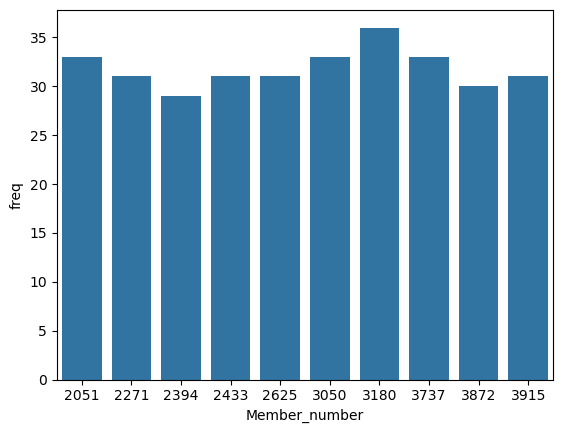

In [164]:
# Most frequent customer
sb.barplot(data=top_10 , y="freq",x="Member_number")

In [165]:
# on which week Day most sales Occured
df["DAY_in_week"]=df["day_of_week"].replace({0:"SUN",1:"MON",2:"TUE",3:"WED",4:"THU",5:"FRI",6:"SAT"})
day_sort= sort(df,"DAY_in_week")
day_sort

,DAY_in_week,freq
0,WED,5754
1,TUE,5663
2,SAT,5624
3,MON,5524
4,THU,5504
5,FRI,5397
6,SUN,5299


<Axes: xlabel='DAY_in_week', ylabel='freq'>

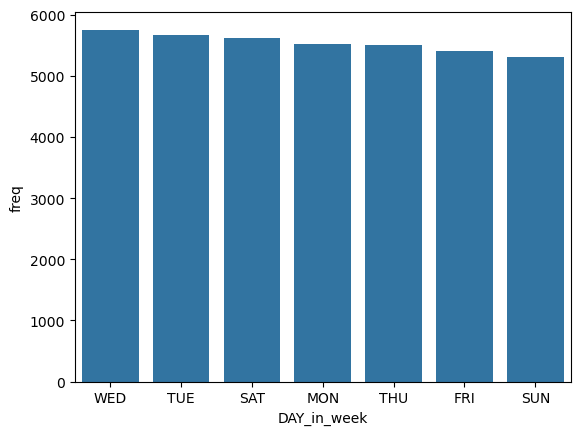

In [166]:
# highest Sales on which week-day
sb.barplot(data=day_sort ,y="freq",x="DAY_in_week")

In [167]:
#Item which is on most sale
items_sort= sort(df,"itemDescription")
items_sort

,itemDescription,freq
0,whole milk,2502
1,other vegetables,1898
2,rolls/buns,1716
3,soda,1514
4,yogurt,1334
...,...,...
162,make up remover,5
163,bags,4
164,baby cosmetics,3
165,kitchen utensil,1


In [168]:
#answer : "whole milk" was in most sale
#Most top 10 sale items :
items_top10=pd.DataFrame(items_sort.iloc[0:10])
items_top10 
#these are the most frequently bought and important items

,itemDescription,freq
0,whole milk,2502
1,other vegetables,1898
2,rolls/buns,1716
3,soda,1514
4,yogurt,1334
5,root vegetables,1071
6,tropical fruit,1032
7,bottled water,933
8,sausage,924
9,citrus fruit,812


<Axes: xlabel='itemDescription', ylabel='freq'>

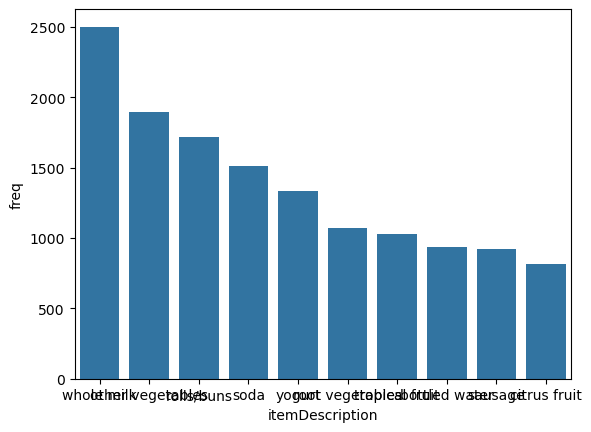

In [169]:
#bar plot of items most bought
sb.barplot(data=items_top10 , x="itemDescription", y="freq")

In [170]:
# Customer Clustering for Behaviour Analysis :

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime

#clustering categories : 
#Cluster 0: Frequent small buyers (high frequency, small basket)
# Cluster 1: Bulk buyers(large basket)
# Cluster 2: Occasional buyers(low frequency)

# to get this clustering we need frequency of customers and basket size

In [171]:
def create_customer_features(df):
     df_copy= df.copy()
     df_copy['Date'] =pd.to_datetime(df_copy['Date'])
     transactions =df_copy.groupby(['Member_number','Date']).size().reset_index(name='items_per_transaction')
     # this transaction gives number of items per transaction on that date
     customer_features =df_copy.groupby('Member_number').agg({
        'Date': ['count', 'min', 'max'], # transaction count, first purchase, last purchase
        'itemDescription':['count'] # total items, unique items
     }).reset_index()  
     customer_features.columns =['Member_number', 'total_transactions', 'first_purchase', 
                                  'last_purchase', 'total_items']
     customer_features['days_active'] = (customer_features['last_purchase'] - customer_features['first_purchase']).dt.days + 1
     customer_features['purchase_frequency']= customer_features['total_transactions'] / customer_features['days_active'].replace(0, 1)
     avg_basket= transactions.groupby('Member_number')['items_per_transaction'].mean().reset_index()
     avg_basket.columns =['Member_number','avg_basket_size']
     customer_features =customer_features.merge(avg_basket, on='Member_number', how='left')
     return customer_features

In [172]:
customer_features =create_customer_features(df)
print(f"Created features for {len(customer_features)}customers")
customer_features.head()

Created features for 3898customers


,Member_number,total_transactions,first_purchase,last_purchase,total_items,days_active,purchase_frequency,avg_basket_size
0,1000,13,2014-06-24,2015-11-25,13,520,0.025000,2.600
1,1001,12,2014-07-02,2015-04-14,12,287,0.041812,2.400
2,1002,8,2014-04-26,2015-08-30,8,492,0.016260,2.000
3,1003,8,2014-01-19,2015-10-02,8,622,0.012862,2.000
4,1004,21,2014-01-05,2015-02-12,21,404,0.051980,2.625


In [173]:
#clustering
features_for_clustering = customer_features[['total_transactions', 'avg_basket_size',
                                             'purchase_frequency']].copy()
scaler =StandardScaler()
features_scaled =scaler.fit_transform(features_for_clustering)
#features_scaled_df = pd.DataFrame(features_scaled)
#features_scaled_df.head()
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_features['cluster'] =kmeans.fit_predict(features_scaled)
print("Clustering completed!")

Clustering completed!


In [174]:
print("\nCluster distribution:")
print(customer_features['cluster'].value_counts().sort_index())


Cluster distribution:
cluster
0     354
1    2466
2    1078
Name: count, dtype: int64


In [175]:
cluster_stats = customer_features.groupby('cluster').agg({
    'total_transactions': 'mean',
    'avg_basket_size': 'mean',
    'purchase_frequency': 'mean',
}).round(2)
cluster_stats

,total_transactions,avg_basket_size,purchase_frequency
cluster,,,
0,2.58,2.55,2.55
1,8.26,2.35,0.03
2,16.23,3.15,0.04


In [176]:
#Identify bulk buyers (highest basket size)
bulk_idx =cluster_stats.sort_values('avg_basket_size', ascending=False).index[0]
print(bulk_idx) #2 -> bulk buyers cluster

2


In [177]:

# Identify occasional buyers(lowest frequency)
remaining_for_occasional = cluster_stats[cluster_stats.index != bulk_idx]
occasional_idx = remaining_for_occasional.sort_values('purchase_frequency', ascending=True).index[0]
print(occasional_idx) # 1 -> occasional buyers cluster

1


In [178]:
#  Identify frequent small buyers (remaining cluster)
all_clusters= set(cluster_stats.index)
freq_small_idx =list(all_clusters - {bulk_idx, occasional_idx})[0]
print(freq_small_idx) # 0 -> is the frequent small buyers cluster

0


In [179]:
# Behavior and strategy mapping
behavior_strategy = {
    0: {'behavior': 'Frequent small buyers', 'strategy': 'Combo offers'},
    1: {'behavior': 'Bulk buyers', 'strategy': 'Wholesale discounts'},
    2: {'behavior': 'Occasional buyers', 'strategy': 'Coupons'}
}


In [180]:
cluster_mapping ={}
cluster_mapping[freq_small_idx] = 0  # Map to Cluster 0: Frequent small buyers
cluster_mapping[bulk_idx] =1        # Map to Cluster 1: Bulk buyers
cluster_mapping[occasional_idx] = 2  # Map to Cluster 2: Occasional buyers

customer_features['behavior_cluster'] = customer_features['cluster'].map(cluster_mapping)
customer_features['behavior_cluster'] 

0       2
1       2
2       2
3       2
4       1
       ..
3893    1
3894    2
3895    0
3896    1
3897    2
Name: behavior_cluster, Length: 3898, dtype: int64

In [181]:
# Function to get customer behavior and strategy
def get_customer_behavior(customer_id):
    if customer_id not in customer_features['Member_number'].values:
        return {
            f"customer_id : {customer_id} data not found"
        }
    customer_data= customer_features[customer_features['Member_number'] == customer_id].iloc[0]
    cluster = int(customer_data['behavior_cluster'])
    return {
        'customer_id': customer_id,
        'cluster': cluster,
        'behavior': behavior_strategy[cluster]['behavior'],
        'strategy': behavior_strategy[cluster]['strategy']
    }

In [182]:
test_customer =customer_features['Member_number'].iloc[0]
result =get_customer_behavior(test_customer)
print("Sample customer behavior:")
for key, value in result.items():
    print(f"{key}:{value}")

Sample customer behavior:
customer_id:1000
cluster:2
behavior:Occasional buyers
strategy:Coupons


In [183]:
# Basket Analysis
dfb= pd.read_csv("basket.csv")
dfb.head()

,0,1,2,3,4,5,6,7,8,9,10
0,whole milk,pastry,salty snack,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sausage,whole milk,semi-finished bread,yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,soda,pickled vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,canned beer,misc. beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sausage,hygiene articles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [184]:
df_bool =(
    dfb
    .stack()         # convert wide → long
    .reset_index(drop=True)
    .rename('item')  )
df_bool = pd.get_dummies(df_bool)

# group back by transaction
df_bool= df_bool.groupby(df_bool.index // dfb.shape[1]).max()

df_bool =df_bool.astype(bool)

In [185]:
co_occurrence =df_bool.astype(int).T.dot(df_bool).astype(int)
co_occurrence.sample(5)

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
whipped/sour cream,5,44,4,6,0,0,18,2,79,51,...,12,8,53,606,2,68,26,297,171,6
frankfurter,5,51,2,6,2,1,16,3,61,44,...,11,13,43,92,1,49,26,271,147,7
frozen fruits,0,0,0,0,0,0,0,1,1,0,...,0,0,1,1,0,2,1,7,4,0
fruit/vegetable juice,7,45,1,5,0,2,12,2,62,44,...,9,2,36,67,2,36,18,248,134,14
pudding powder,1,1,0,0,0,0,1,0,2,3,...,0,0,3,3,0,2,0,10,2,1


In [186]:
# pick top 10 most frequent items
top_items =(
    co_occurrence.sum(axis=1)
    .sort_values(ascending=False)
    .head(10)
    .index  )

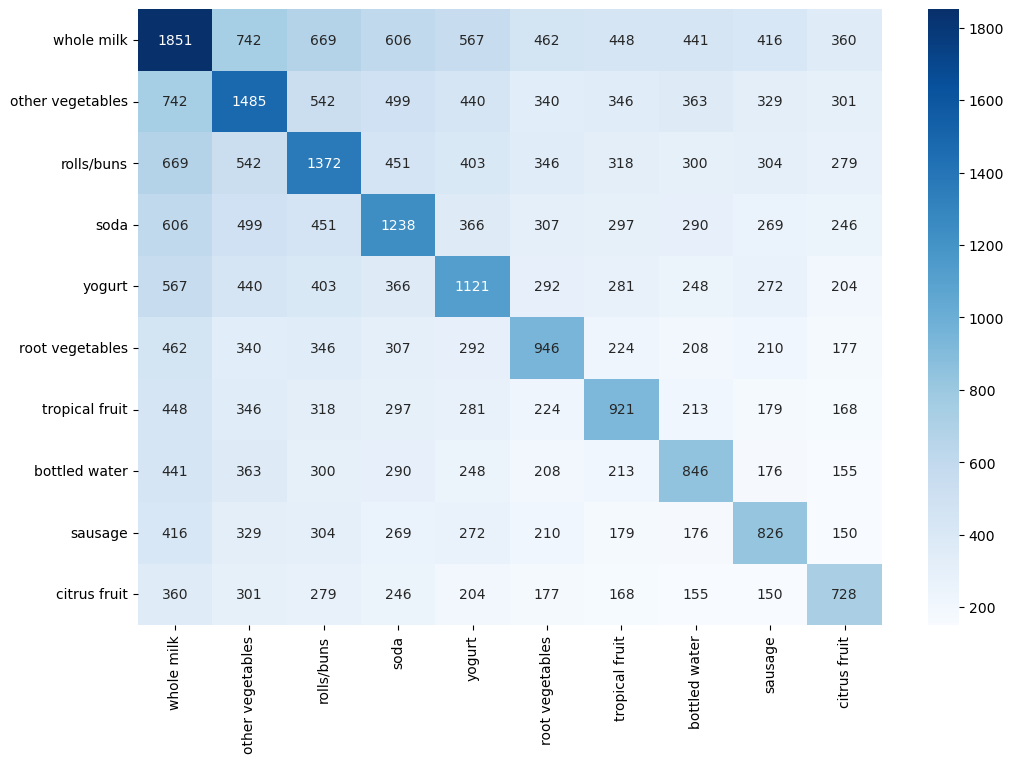

In [187]:
# this heat map show how two items are frequently bought together
plt.figure(figsize=(12, 8))
sb.heatmap(
    co_occurrence.loc[top_items, top_items],
    annot=True,
    fmt='d',
    cmap='Blues'  )
plt.show()


In [188]:
#implementing Apriori algorithm for Recommendation 
from mlxtend.frequent_patterns import apriori
support_df=apriori(df_bool , min_support=0.01 ,use_colnames=True , max_len=2).sort_values(by="support", ascending=False)
support_df

,support,itemsets
115,0.525106,(whole milk)
71,0.421277,(other vegetables)
86,0.389220,(rolls/buns)
96,0.351206,(soda)
116,0.318014,(yogurt)
...,...,...
690,0.010213,"(dishes, tropical fruit)"
693,0.010213,"(dog food, whole milk)"
590,0.010213,"(coffee, frozen meals)"
478,0.010213,"(whole milk, canned vegetables)"


In [189]:
support_df['itemsets'].apply(len).value_counts()

itemsets
2    1111
1     118
Name: count, dtype: int64

In [190]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(
    support_df,
    metric="confidence",
    min_threshold=0.5
)

In [191]:
rules.sample(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
14,(chocolate),(whole milk),0.098156,0.525106,0.049078,0.500000,0.952188,1.0,-0.002464,0.949787,-0.052741,0.085474,-0.052867,0.296731
40,(mustard),(whole milk),0.025248,0.525106,0.013333,0.528090,1.005682,1.0,0.000075,1.006322,0.005796,0.024828,0.006282,0.276741
4,(bottled beer),(whole milk),0.179574,0.525106,0.091348,0.508689,0.968735,1.0,-0.002948,0.966584,-0.037850,0.148936,-0.034571,0.341324
15,(hamburger meat),(whole milk),0.090496,0.525106,0.047943,0.529781,1.008901,1.0,0.000423,1.009940,0.009701,0.084458,0.009843,0.310541
2,(sausage),(whole milk),0.234326,0.525106,0.118014,0.503632,0.959105,1.0,-0.005032,0.956737,-0.052751,0.183989,-0.045219,0.364188


In [192]:
def recommend_items(basket, rules, top_n=5):
    basket = set(basket)
    matched= rules[rules['antecedents'].apply(lambda a: a.issubset(basket))]
    matched =matched.sort_values(['confidence', 'lift'], ascending=False)
    recom = [
        item
        for consequents in matched['consequents']
        for item in consequents
        if item not in basket
    ]

    return list(dict.fromkeys(recom))[:top_n]

In [193]:
def recommend_with_customer_behavior(customer_id, rules, top_n=5):
    customer_info = get_customer_behavior(customer_id)
    customer_purchases =df[df['Member_number'] == customer_id]['itemDescription'].unique()
    if len(customer_purchases) == 0:
        return {
            'customer_id': customer_id,
            'behavior': customer_info['behavior'],
            'strategy': customer_info['strategy'],
            'recommendations': [],
            'message': 'No purchase history found for recommendations'
        }
    basket =list(customer_purchases[:10])    
    recommendations= recommend_items(basket, rules, top_n)
    
    return {
        'customer_id': customer_id,
        'cluster': customer_info['cluster'],
        'behavior': customer_info['behavior'],
        'strategy': customer_info['strategy'],
        'recommendations': recommendations,  }


In [194]:
test_customer= customer_features['Member_number'].iloc[0]
result =recommend_with_customer_behavior(test_customer, rules)
print("Enhanced Recommendation Result:")
#print(result)
for key, value in result.items():
    print(f"{key}: {value}")


Enhanced Recommendation Result:
customer_id: 1000
cluster: 2
behavior: Occasional buyers
strategy: Coupons
recommendations: []


In [195]:
test_customer =customer_features['Member_number'].iloc[7]
result= recommend_with_customer_behavior(test_customer, rules)
print("Enhanced Recommendation Result:")
#print(result)
for key, value in result.items():
    print(f"{key}: {value}")


Enhanced Recommendation Result:
customer_id: 1008
cluster: 1
behavior: Bulk buyers
strategy: Wholesale discounts
recommendations: ['whole milk']
